Написать на PyTorch forward и backward полносвязного слоя без использования autograd

Написать 1-2 адаптивных оптимизатора

Решить задачу нахождения корней квадратного уравнения методом градиентного спуска

### Реализация полносвязного слоя с forward и backward

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn

In [2]:
def sigmoid(z):
    return 1./(1+np.exp(-z))

def loss(t, y):
    return np.sum((t-y)**2, keepdims=True).flatten()*0.5

def diff_loss(t, y):
    return np.sum(np.abs(y-t), kkepdims=True).flatten()

In [3]:
class Layer:
    
    def __init__(self, n_inp, n_out, lr=0.1):
        self.shape = (n_inp, n_out)
        self.lr = lr
        self.w = np.zeros(self.shape, dtype=np.float32)
        self.b = np.zeros((1, n_out), dtype=np.float32)
        self._clear_grads()
    
    def _clear_grads(self):
        self.inp = None
        self.activations = None
        self.d_sigma = None
        self.d_w = None
        self.d_b = None
    
    def __call__(self, x):
        print('asdfasd')
        if len(x.shape) == 1:
            x = x.reshape(1, -1)
        self.inp = x
        self.activations = sigmoid(x.dot(self.w) + self.b)
        return self.activations
    
    def backward(self, grad):
        self.d_sigma = self.activations * (1 - self.activations)
        self.d_w = self.grad_w(grad)
        self.d_b = self.grad_b(grad)
        return self.grad_x(grad)
    
    def grad_w(self, grad):
        return grad * self.inp.T * self.d_sigma
    
    def grad_b(self, grad):
        return grad * self.d_sigma
    
    def grad_x(self, grad):
        return self.w.dot(grad) * self.d_sigma
    
    def step(self):
        self.w -= self.d_w * self.lr
        self.b -= self.d_b * self.lr
        self._clear_grads()
        
l1 = Layer(5, 1)

### Пример оптимизатора из лекции:

In [4]:
class SGDMomentum:
    
    def __init__(self, 
                 model, 
                 lr = 0.01, 
                 momentum = 0.9 ):
        self.model = model
        self.lr = lr
        self.momentum = momentum
        self.velocity = torch.zeros_like(model)
        
    def step(self, grad):
        self.velocity = self.momentum * self.velocity - self.lr * grad
        self.model += self.velocity
        

### Пример реализации оптимизатора Adam:

https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be

https://miro.medium.com/max/1400/1*FnZxx-ssZXdTzIuuf1NEzw.png

In [5]:
class Adam:
    
    def __init__(self, model, a, 
                 m = 0,
                 v = 0,
                 t = 0,
                 b1 = 0.9, 
                 b2 = 0.999, 
                 eps = 10 ** (-8) ):
        self.model = model
        self.a = a
        self.m = m
        self.v = v
        self.t = t
        self.b1 = b1
        self.b2 = b2
        self.eps = eps
    
    def step(self, grad):
        self.t += 1
        self.m = self.b1 * self.m + (1 - self.b1) * grad
        self.v = self.b2 * self.v + (1 - self.b2) * grad
        m_bias = self.m / (1-self.b1)
        v_bias = self.v / (1-self.b2)
        self.model -= (self.a * m_bias) / (v_bias**0.5 + self.eps)

### Поиск пересечения с осью x линии y = 2*x - 7 методом градиентного спуска (пример из лекции):

In [6]:
y = lambda x: 2 * x - 7
f = lambda x: (2 * x - 7)**2
g = lambda x: 2*(2 * x - 7)
x = np.arange(-10, 10, 0.1)

def solver(init_x):
    x = torch.tensor(init_x, dtype=torch.float32)
    grad = g(x)
    optim = Adam(x, 0.01)
    for i in range(1000):
        optim.step(grad)
        grad = g(optim.model)
    print(optim.model)  
    
solver(6)

tensor(3.5000)


### Поиск квадратных корней уравнения методом градиентного спуска

f(x) = -4x^2 + 4x + 1

1 корень

x1 = 0.5

ветви направлены вниз

In [7]:
a, b, c = -4, 4, 1

f = lambda x: (a*x**2 + b*x + c)
g = lambda x: -(2*a*x + b) # знак "-" т.к. экстремум изначальной функции f в точке максимума а не минимума

def solver(init_x):
    x = torch.tensor(init_x, dtype=torch.float32)
    grad = g(x)
    optim = Adam(x, 0.01)
    for i in range(1000):
        optim.step(grad)
        grad = g(optim.model)
    print(optim.model)
    
solver(6)

tensor(0.5000)


### пример 2

f(x) = x^2 + 3x + 1

2 корня

x1 ≈ -2.6180 , x2 ≈ -0.38197

ветви направлены вверх

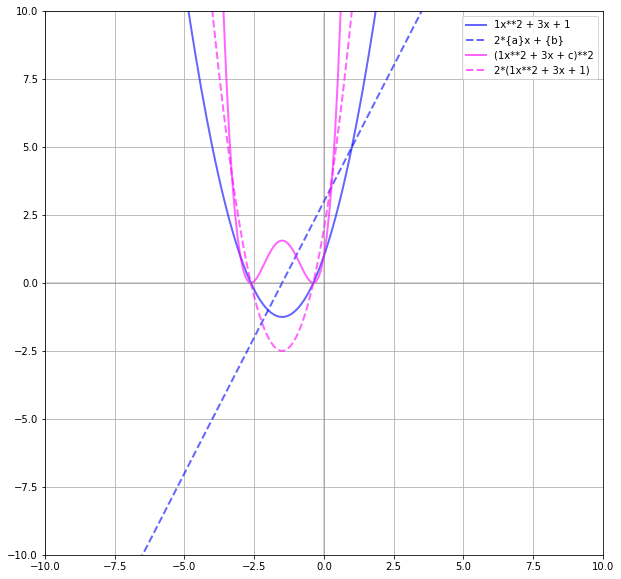

tensor(-1.5000)
tensor(-0.3820)


In [8]:
a,b,c = 1,3,1

f = lambda x: (a*x**2 + b*x + c)
g = lambda x: 2*a*x + b

f1 = lambda x: (a*x**2 + b*x + c)**2
g1 = lambda x: 2*(a*x**2 + b*x + c)

x = np.arange(-10, 10, 0.1)
plt.figure(figsize=[10,10])


plt.plot(x, [f(i) for i in x], color='blue', alpha=.6, linewidth=2, label=f'{a}x**2 + {b}x + {c}')
plt.plot(x, [g(i) for i in x], color='blue', alpha=.6, linewidth=2, linestyle=f'dashed', label='2*{a}x + {b}')
plt.plot(x, [f1(i) for i in x], color='magenta', alpha=.6, linewidth=2, label=f'({a}x**2 + {b}x + c)**2')
plt.plot(x, [g1(i) for i in x], color='magenta', alpha=.6, linewidth=2, linestyle='dashed', label=f'2*({a}x**2 + {b}x + {c})')

plt.plot(x, [0 for _ in x], color='gray', alpha=.4)
plt.plot([0 for _ in x], x, color='gray', alpha=.4)
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.grid(axis='both') 
plt.legend()
plt.show()

def solver(init_x, g):
    x = torch.tensor(init_x, dtype=torch.float32)
    grad = g(x)
    optim = Adam(x, 0.01)
    for i in range(2000):
        optim.step(grad)
        grad = g(optim.model)
    print(optim.model)
    
solver(6, g) # находит x-экстремума основной функции
solver(6, g1) # находит один из корней

т.к. 2 корня равноудалены от центра параболы, то их значения равны x(экстремума) +- расстояние до любого из них

In [9]:
extrem_x = -1.5
diff = abs(extrem_x - (-0.3820))
first_root = extrem_x - diff
second_root = extrem_x + diff
print(f'корни уравнения - x1≈{first_root} x2≈{second_root}')

корни уравнения - x1≈-2.618 x2≈-0.3820000000000001
